# Ours

our code

In [2]:
import os
import math
from shutil import copyfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.backends.cudnn as cudnn
from torchvision.transforms import InterpolationMode
from torchvision import models

import numpy as np
import random

from utils.common import setup_seed 
# from utils.loader import environments, init_dataset_train
from torch import nn
from tqdm import tqdm
from torch.utils.data import Subset, DataLoader

from torch.nn import functional as F
from MLPN.loader import init_dataset_train
from utils.loader import  init_dataset_test, environments, tensor2label, label2tensor, init_dataset_test
from utils.metrics import metrics
from MLPN.model import CSWinTransv2_threeIn
from MLPN.utils import extract_feature, get_id, extract_feature, SAM, SupConLoss, one_LPN_output

from tqdm.contrib import tzip

import tarfile
import zipfile

from LPN.image_folder_ import CustomData160k_drone, CustomData160k_sat
from utils.competition import get_result_rank10, get_SatId_160k


class DomainClassifier(nn.Module):
    def __init__(self, domin_num=10) -> None:
        super(DomainClassifier, self).__init__()
        
        # adatped from modern backbone, change last fc to adopt domain
        self.net = models.resnet18(pretrained=True)
        ftr_num = self.net.fc.in_features
        self.net.fc = nn.Linear(ftr_num, domin_num)

    def forward(self, x):
        return self.net(x)
    

class WeatherFilter(nn.Module):
    def __init__(self, domin_num=10, h=256, w=256, channel=3) -> None:
        super(WeatherFilter, self).__init__()
        self.learnable_filters = nn.Parameter(torch.randn(domin_num, channel, h, w))

    def forward(self, weather_vec):
        weighted_filter = torch.einsum('bk,kchw->bcwh', weather_vec, self.learnable_filters)
        return weighted_filter
    
class FDM(nn.Module):
    def __init__(self, domin_num=10, h=256, w=256, channel=3) -> None:
        super(FDM, self).__init__()
        self.filter_invariant = WeatherFilter(domin_num=domin_num, h=h, w=w, channel=channel)
        self.filter_specific = WeatherFilter(domin_num=domin_num, h=h, w=w, channel=channel)

    def forward(self, img, vec):
        fft_img = torch.fft.fftn(img, dim=(-2,-1))
        amplitude = torch.abs(fft_img)
        phase = torch.angle(fft_img)

        fi = self.filter_invariant(vec)
        fs = self.filter_specific(vec)

        spec_invariant = fi * amplitude 
        spec_specific = fs * amplitude

        component_invariant = torch.real(torch.fft.ifftn(torch.polar(spec_invariant, phase), dim=(-2,-1)))
        component_specific = torch.real(torch.fft.ifftn(torch.polar(spec_specific, phase), dim=(-2,-1)))

        return component_invariant, component_specific

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin 

    def forward(self, out1, out2, label):
        ed = nn.functional.pairwise_distance(out1, out2)
        loss = torch.mean(
            (1-label)*torch.pow(ed, 2)+label*torch.pow(torch.clamp(self.margin-ed, min=0.0), 2)
        )
        return loss 
    

class Ours:
    def __init__(self, 
                 use_wandb=True,
                 wandb_key = '16c9a3f92163ef4df08841029e02fded0cd0cfed'
                 ) -> None:
        self.seed = 2024
        self.use_wandb = use_wandb # use wandb to monitor training instead of CLI
        self.wandb_key = wandb_key
        # init
        setup_seed(self.seed)
        self.model_dir = os.path.join(os.getcwd(), 'model', 'Ours')
        os.environ['TORCH_HOME']='./' 
        
        # 
        # self.domain_classifer = DomainClassifier() 

    def train(self, 
              data_dir=None,
              style='mixed', 
              model_name1='FDM',
              model_name2='MLPN',
              num_epochs=210,
              lr = 0.005,
              batchsize = 8,
              block = 4,
              checkpoint_interval = 10,
              checkpoint_start = 40,
              droprate = 0.75,
              fix_img = True, # preprocess only once
              num_worker_imgaug = 16,
              margin = 1.0
              ):
        # use wandb to log
        if self.use_wandb:
            import wandb
            os.environ["WANDB_API_KEY"] = self.wandb_key
            wandb.init(project="ACMMMW24", name=model_name1)
        if data_dir==None:
            data_dir = os.path.join(os.getcwd(), 'University-Release', 'train')
        image_datasets, dataloaders, dataset_sizes = init_dataset_train(data_dir, batchsize=batchsize, style=style, num_worker_imgaug=num_worker_imgaug)

        # fix setting that
        # ====================
        # LPN: true
        # SAM: 1
        # balance: true 
        # infonce: 1
        # decouple: false
        # only_decouple: false 
        # moving_avg: 1.0
        # warm_epoch: 0 --> No Warmup
        # extra_Google: false
        # select_id: false
        # normal: false --> dataloader give couple

        model = CSWinTransv2_threeIn(701, droprate=droprate, decouple=False, infonce=1)
        model = model.cuda()
        model.train(True) 

        ignored_params = list()
        for i in range(block):
            cls_name = 'classifier' + str(i)
            c = getattr(model, cls_name)
            ignored_params += list(map(id, c.parameters()))
        base_params = filter(lambda p: id(p) not in ignored_params, model.parameters())
        optim_params = [{'params': base_params, 'lr': 0.1 * lr}]
        for i in range(block):
            cls_name = 'classifier' + str(i)
            c = getattr(model, cls_name)
            optim_params.append({'params': c.parameters(), 'lr': lr})

        infonce = SupConLoss(temperature=0.1)
        # SAM = 1
        base_optimizer = torch.optim.SGD
        optimizer_ft = SAM(optim_params, base_optimizer, lr=lr, weight_decay=5e-4, momentum=0.9, nesterov=True)
        exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[120, 180, 210], gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        bestAcc, bestAp, bestEp = 0, 0, 0 

        #### OUR FDM Module
        fdm = FDM()
        fdm = fdm.cuda()
        fdm.train(True) 
        fdm_loss = ContrastiveLoss(margin=margin)


        if fix_img: # significant speed up, since imgaug is rather slow
            dataloader_drone = list()
            dataloader_sat = list()
            for data, data3 in tzip(dataloaders['drone'], dataloaders['satellite']):
                dataloader_drone.append(data)
                dataloader_sat.append(data3)
            print('done synthesis {} style image'.format(style))
        else:
            dataloader_drone = dataloaders['drone']
            dataloader_sat = dataloaders['satellite']


        for epoch in range(1, num_epochs+1):
            running_loss, running_corrects, running_corrects3 = 0.0, 0.0, 0.0
            ins_loss, dec_loss, on_loss, off_loss = 0.0, 0.0, 0.0, 0.0
            lossinfo1, lossinfo2 = 0.0, 0.0 
            lossfdm1, lossfdm2 = 0.0, 0.0
            optimizer = optimizer_ft
            # Iterate over data.
            for data, data3 in tzip(dataloader_sat, dataloader_drone):
                # get the inputs
                inputs, inputs_d, labels, weather_vec = data
                inputs3, inputs3_s, labels3, weather_vec3 = data3
                now_batch_size, c, h, w = inputs.shape
                if now_batch_size < batchsize:  # skip the last batch
                    continue
                
                inputs = Variable(inputs.cuda().detach())
                inputs_d = Variable(inputs_d.cuda().detach())
                inputs3 = Variable(inputs3.cuda().detach())
                inputs3_s = Variable(inputs3_s.cuda().detach())
                labels = Variable(labels.cuda().detach())
                labels3 = Variable(labels3.cuda().detach())
                weather_vec = Variable(weather_vec.cuda().detach())
                weather_vec3 = Variable(weather_vec3.cuda().detach())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward FDM
                inputs_d_ci, inputs_d_cs = fdm(inputs_d)
                inputs3_ci, inputs3_cs = fdm(inputs3)

                # forward (invariant part and satellite img)
                outs_c, outs_info = model(inputs) # decouple: false
                outs_d_c, outs_d_info = model(inputs_d_ci) # balance: true and infonce: 1 

                outd_c, outd_info = model(inputs3_ci)
                outs3_s_c, outs3_s_info = model(inputs3_s)

                # calculate loss 
                preds, loss = one_LPN_output(outs_c, labels, criterion, block)
                _, loss_d = one_LPN_output(outs_d_c, labels, criterion, block)
                loss = loss + loss_d
                preds3, loss3 = one_LPN_output(outd_c, labels3, criterion, block)
                _, loss3_s = one_LPN_output(outs3_s_c, labels3, criterion, block)
                loss3 = loss3 + loss3_s
                loss = (loss + loss3) / 2

                sate = F.normalize(outs_info, dim=1)
                drone = F.normalize(outd_info, dim=1)
                sate_ = F.normalize(outs_d_info, dim=1)
                drone_ = F.normalize(outs3_s_info, dim=1)
                features1 = torch.cat([sate.unsqueeze(1), sate_.unsqueeze(1)], dim=1)
                features2 = torch.cat([drone.unsqueeze(1), drone_.unsqueeze(1)], dim=1)
                loss_info = infonce(features1, labels)
                loss = loss + loss_info
                loss_info1 = infonce(features2, labels3)
                loss = loss + loss_info1

                # fdm (specific part, for FDM)
                outs_d_c_s, _ = model(inputs_d_cs)
                outd_c_s, _ = model(inputs3_cs)

                fdm_inputs_loss = fdm_loss(outs_d_c, outs_d_c_s, weather_vec)
                fdm_inputs3_loss = fdm_loss(outd_c, outd_c_s, weather_vec3)
                loss = loss + fdm_inputs_loss + fdm_inputs3_loss

                # backward
                loss.backward()
                optimizer.first_step(zero_grad=True)

                # again
                # forward FDM
                inputs_d_ci, inputs_d_cs = fdm(inputs_d)
                inputs3_ci, inputs3_cs = fdm(inputs3)

                # forward (invariant part and satellite img)
                outs_c, outs_info = model(inputs) # decouple: false
                outs_d_c, outs_d_info = model(inputs_d_ci) # balance: true and infonce: 1 

                outd_c, outd_info = model(inputs3_ci)
                outs3_s_c, outs3_s_info = model(inputs3_s)

                # calculate loss 
                preds, loss = one_LPN_output(outs_c, labels, criterion, block)
                _, loss_d = one_LPN_output(outs_d_c, labels, criterion, block)
                loss = loss + loss_d
                preds3, loss3 = one_LPN_output(outd_c, labels3, criterion, block)
                _, loss3_s = one_LPN_output(outs3_s_c, labels3, criterion, block)
                loss3 = loss3 + loss3_s
                loss = (loss + loss3) / 2

                sate = F.normalize(outs_info, dim=1)
                drone = F.normalize(outd_info, dim=1)
                sate_ = F.normalize(outs_d_info, dim=1)
                drone_ = F.normalize(outs3_s_info, dim=1)
                features1 = torch.cat([sate.unsqueeze(1), sate_.unsqueeze(1)], dim=1)
                features2 = torch.cat([drone.unsqueeze(1), drone_.unsqueeze(1)], dim=1)
                loss_info = infonce(features1, labels)
                loss = loss + loss_info
                loss_info1 = infonce(features2, labels3)
                loss = loss + loss_info1

                # fdm (specific part, for FDM)
                outs_d_c_s, _ = model(inputs_d_cs)
                outd_c_s, _ = model(inputs3_cs)

                fdm_inputs_loss = fdm_loss(outs_d_c, outs_d_c_s, weather_vec)
                fdm_inputs3_loss = fdm_loss(outd_c, outd_c_s, weather_vec3)
                loss = loss + fdm_inputs_loss + fdm_inputs3_loss

                loss.backward()
                optimizer.second_step(zero_grad=True)

                # statistics
                running_loss += loss.item() * now_batch_size 
                lossinfo1 += loss_info.item() * now_batch_size
                lossfdm1 += fdm_inputs_loss.item() * now_batch_size 
                lossfdm2 += fdm_inputs3_loss.item() * now_batch_size 
                running_corrects += float(torch.sum(preds == labels.data))
                running_corrects3 += float(torch.sum(preds3 == labels3.data))

            epoch_loss = running_loss / dataset_sizes['satellite']
            epoch_acc = running_corrects / dataset_sizes['satellite']
            epoch_acc3 = running_corrects3 / dataset_sizes['satellite']

            epoch_loss_info1 = lossinfo1 / dataset_sizes['satellite']
            epoch_loss_fdm1 = lossfdm1 / dataset_sizes['satellite']
            epoch_loss_fdm2 = lossfdm2 / dataset_sizes['satellite']

            print('{} Loss: {:.4f} Satellite_Acc: {:.4f} Drone_Acc: {:.4f} infoloss1: {:.4f} fdm1loss: {:.4f} fdm2loss: {:.4f} '.format(
                epoch, epoch_loss, epoch_acc,
                epoch_acc3, epoch_loss_info1, epoch_loss_fdm1, epoch_loss_fdm2))
            
            if self.use_wandb:
                wandb.log({'Loss': epoch_loss, 
                            'Satellite_Acc': epoch_acc,
                            'Drone_Acc': epoch_acc3,
                            'infoloss1': epoch_loss_info1,
                            'fdm1loss': epoch_loss_fdm1,
                            'fdm2loss': epoch_loss_fdm2
                            })
            
            exp_lr_scheduler.step()

            if epoch % checkpoint_interval == 0 and epoch > checkpoint_start:     
                save_filename = '{}_{:03d}.pth'.format(model_name2, epoch)
                save_path = os.path.join(os.path.join(self.model_dir, save_filename))
                torch.save(model.cpu().state_dict(), save_path)
                model.cuda() # essential!   
                save_filename = '{}_{:03d}.pth'.format(model_name1, epoch)
                torch.save(fdm.cpu().state_dict(), save_path)
                fdm.cuda()
        

    def train_domain_classifier(self,
                name='DomainClassifier',
                lr=0.001,
                num_epochs=60,
                batchsize=16,
                h=256,
                w=256,
                train_num=None,
                dataset='University-Release',
                checkpoint_interval=20,
                checkpoint_start=10,
                ):
        # load Dataset
        image_datasets, dataloaders, dataset_sizes = init_dataset_train(name=dataset, w=w, h=h, style='mixed')

        if type(train_num) is int:
            indices = list(range(train_num))
            s_dataset = Subset(image_datasets['drone'], indices)
        else:
            s_dataset = image_datasets['drone']
        s_dataloader = DataLoader(s_dataset, batch_size=batchsize, shuffle=True, num_workers=0) 

        # Create Model
        model = DomainClassifier()
        model = model.cuda()
        model.train(True)  # Set model to training mode

        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # trivial settings
        # use wandb to log
        if self.use_wandb:
            import wandb
            os.environ["WANDB_API_KEY"] = self.wandb_key
            wandb.init(project="ACMMMW24", name=name)
        # save pth
        if not os.path.isdir(self.model_dir):
            os.mkdir(self.model_dir)

        
        for epoch in range(1, num_epochs+1):     
            correct = 0 
            total = 0
            epoch_loss = 0
            for data in tqdm(s_dataloader, ):                                
                # get the inputs
                inputs, labels, weather = data
                now_batch_size,c,h,w = inputs.shape
                if now_batch_size<batchsize: # skip the last batch
                    continue
                wt = label2tensor(weather)
                if torch.cuda.is_available():
                    inputs = inputs.cuda().detach()
                    labels = labels.cuda().detach()
                    wt = wt.cuda().detach()

                # zero the parameter gradients
                optimizer.zero_grad()

                wo = model(inputs)
                loss = criterion(wo, wt)
                sssss = tensor2label(wt)
                xxxxx = tensor2label(wo)

                for i in range(batchsize):
                    if sssss[i] == xxxxx[i]:
                        correct = correct + 1
                total = total + batchsize
                epoch_loss += float(loss.cpu().detach().numpy())
                loss.backward()
                optimizer.step() 
            if self.use_wandb:
                wandb.log({'Loss': epoch_loss, 'Acc': correct/total})
            print("Epoch: {} Loss: {:.4f} Acc: {:.4f}".format(epoch, epoch_loss, correct/total))

            if epoch % checkpoint_interval == 0 and epoch > checkpoint_start:     
                save_filename = '{}_{:03d}.pth'.format(name, epoch)
                save_path = os.path.join(os.path.join(os.getcwd(), "model", name, save_filename))
                torch.save(model.cpu().state_dict(), save_path)
                model.cuda() # essential!

    def test_single_batch(self,
                                      dataset='University-Release',
                                      h=256,
                                      w=256,
                                      batchsize=8,
                                      model_file='DomainClassifier_060.pth'
                                      ):
        # load Dataset
        image_datasets, dataloaders, dataset_sizes = init_dataset_test(name=dataset, w=w, h=h, style='mixed', batchsize=batchsize)
        dataiter = iter(dataloaders['query_drone'])
        img, label, weather = dataiter.next()
        #print(img.shape)
        # print(label)
        
        domain_classifier = DomainClassifier()
        domain_classifier.load_state_dict(torch.load(os.path.join(self.model_dir, model_file))) 
        logits = domain_classifier(img) 
        pred = torch.softmax(logits, dim=1)

        print('weather classifier result')
        print(logits[0])
        print(pred[0])
        print("GT:        ", weather)
        print("predicted: ", tensor2label(logits))

        fdm = FDM()
        ci, cs = fdm(img, pred)
        return ci, cs
            


c:\Users\lyq\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:


a = Ours(use_wandb=False)


In [31]:
a.train()

c:\Users\lyq\.conda\envs\pytorch\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
c:\Users\lyq\.conda\envs\pytorch\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 0/4732 [00:00<?, ?it/s]

In [1]:
import torch 

a = torch.ones(4)
print(a)

tensor([1., 1., 1., 1.])


c:\Users\lyq\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
x = True
print('aaa', 'a' if x else 'b')

aaa a


In [6]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin 

    def forward(self, out1, out2, label):

        indices = torch.argmax(label, dim=1)
        batchsize = out1.shape[0]
        loss = 0
        cnt = batchsize * batchsize - batchsize

        for i in range(batchsize):
            for j in range(batchsize):
                if i==j:
                    continue 
                ed = nn.functional.pairwise_distance(out1[i], out2[j])
                if indices[i]==indices[j]: # positive sample
                    loss = loss + torch.pow(ed, 2)
                else: # negative sample
                    loss = loss + torch.pow(torch.clamp(self.margin-ed, min=0.0), 2)
        loss = loss / cnt 
        return loss


ContrastiveLoss_ = ContrastiveLoss()
aa = torch.randn(8,512)
bb = torch.randn(8,512)
cc = torch.randn(8,10)
loss = ContrastiveLoss_(aa,bb,cc)
print(loss)

tensor(140.5645)


c:\Users\lyq\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\lyq\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weather classifier result
tensor([-12.0296, -33.9666, -63.3576,  -3.8643, -13.3090, -54.2882, -56.4156,
          6.2651,  -5.1515, -39.4315], grad_fn=<SelectBackward0>)
tensor([1.1343e-08, 3.3696e-18, 5.7973e-31, 3.9889e-05, 3.1554e-09, 5.0352e-27,
        5.9994e-28, 9.9995e-01, 1.1011e-05, 1.4262e-20],
       grad_fn=<SelectBackward0>)
GT:         ('rain_snow', 'wind', 'fog_snow', 'snow', 'dark', 'fog_snow', 'fog_snow', 'rain_snow')
predicted:  ['rain_snow', 'wind', 'fog_snow', 'snow', 'dark', 'fog_snow', 'fog_snow', 'rain_snow']


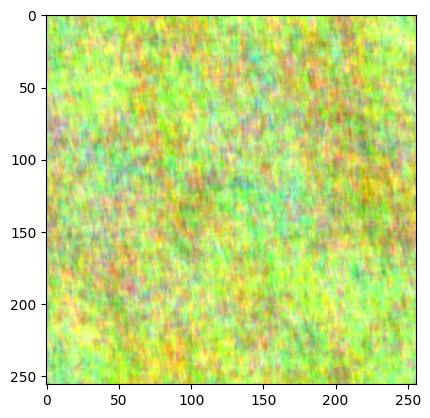

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


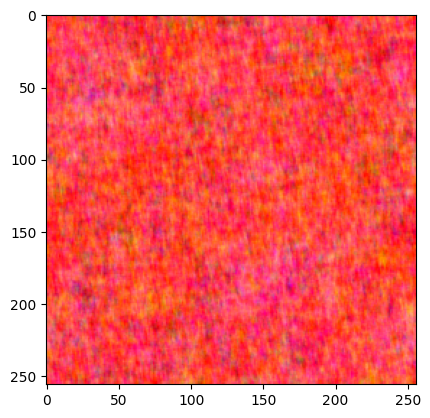

In [21]:
from matplotlib import pyplot as plt
import numpy as np

def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.detach().numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show() 

# a.train_domain_classifier(num_epochs=3,checkpoint_interval=1, checkpoint_start=0)
ci, cs = a.test_single_batch()
imshow(ci[0])
imshow(cs[0])

In [27]:
a = torch.randn(3,512)
aa = torch.randn(3,512)
print(nn.functional.pairwise_distance(a,aa).shape)

torch.Size([3, 512])


In [9]:
import torch 
import numpy as np 


a = torch.randn(3,4)
aa = torch.randn(3,4)
b = torch.randn(3)
#print(a,b)

#for w,f in zip(b,a):
#    print(w*f)

#print(sum(w*f for w,f in zip(b,a)))
print(a,aa)
print(a*aa)

tensor([[-0.0672, -0.9425,  0.8835,  0.6252],
        [-0.0829, -0.3657, -0.8544, -0.8598],
        [-2.7009, -1.2221,  0.9980,  0.6526]]) tensor([[-1.1150, -0.8587,  0.3506,  0.8757],
        [-0.3191,  0.8285, -1.0030, -0.1956],
        [-0.8119, -0.9320,  1.1431,  0.5673]])
tensor([[ 0.0750,  0.8094,  0.3098,  0.5475],
        [ 0.0264, -0.3030,  0.8569,  0.1681],
        [ 2.1929,  1.1390,  1.1408,  0.3702]])


In [5]:
a = [1,2,3]
a = torch.tensor(a)
print(a)

tensor([1, 2, 3])


```
conda activate pytorch
wandb sync d:\acmmm24-ours\wandb\run-20240618_124948-u09o94cy
16c9a3f92163ef4df08841029e02fded0cd0cfed
```